In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner
import datetime

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()
# num of max poisoning points, max 20% poison rate
poison_ct = 328
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

Posion count:  328  Train count:  1319  Test count:  165  Proportion of poisoning:  0.19914996964177292


# Inverse Flip & Lasso Poisoner

classifier:  Lasso(alpha=3.7162432899202766e-05, max_iter=10000, warm_start=True)


*****************************
**** Poison Count:  54  ****
*****************************
Iteration  0 
Objective Value:  0.006453298378130627  Change:  0.006453298378130627
Validation MSE  0.0049007750940744735 
Test MSE  0.006658555366223625
 
Iteration  1
Objective Value: 0.0049774290251420675  Difference:  -0.0014758693529885597
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.004977444748852228  Difference:  -0.0014758536292783994
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.004977456659011368  Difference:  -0.0014758417191192592
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.004977465859022283  Difference:  -0.0014758325191083438
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.004977472752156788  Difference:  -0.0014758256259738388
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.004977478060223878  Difference:  -0.0014758203179067488
NO PROGRESS MADE!
 
Iteration  7
Objective

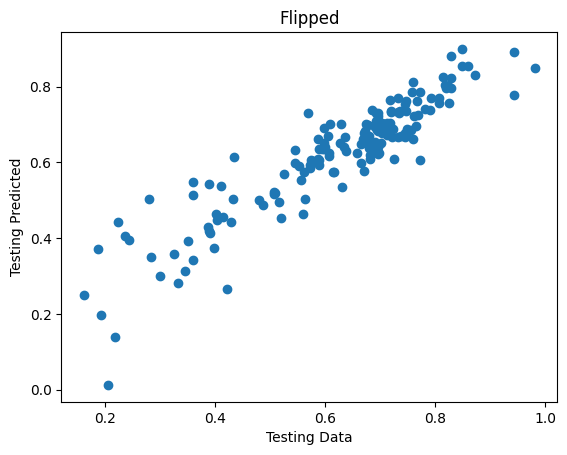

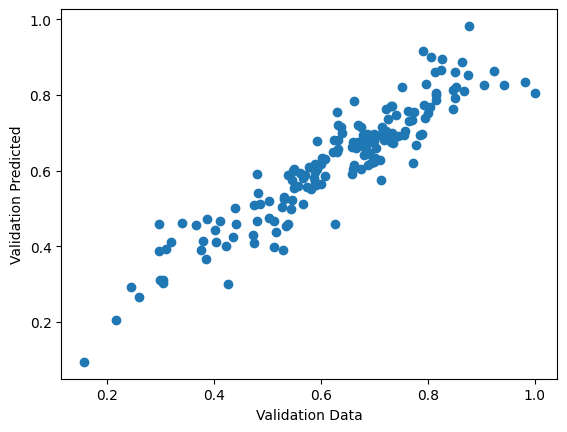

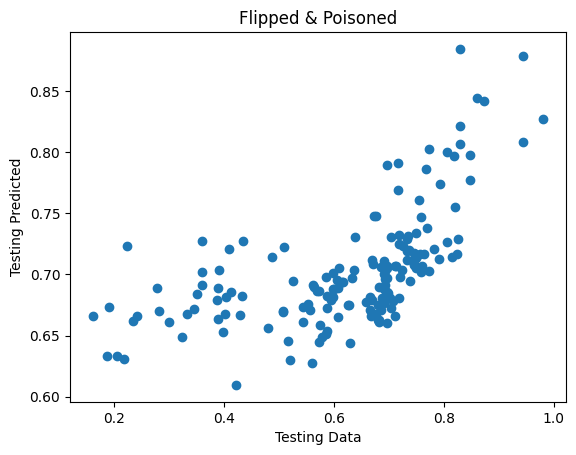

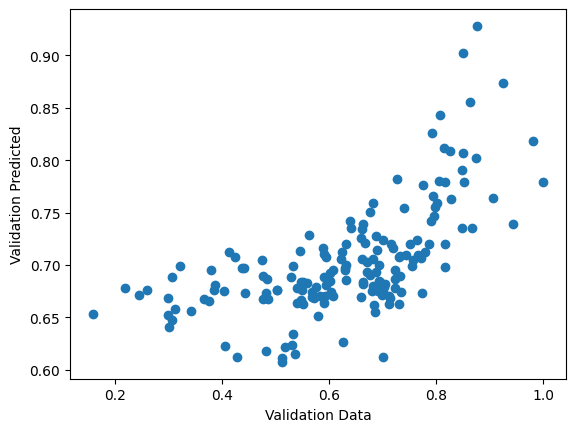


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0037579073460158726 
 Test MSE: 0.004764463167075303

After Flipping & Poisoning:
 Validation MSE:  0.02398921612679378 
 Test MSE: 0.02766423128804222


In [3]:
# define parameters for poisoner
eta = 0.03 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 20
stop2 = 50
stop3 = 10
decrease_rate = 0.75

# flip the data
x_flip, y_flip = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.lasso_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, lam = poiser.learn_model(np.concatenate((poi_train_x, x_flip), axis=0), poi_train_y + y_flip, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_flip = np.matrix(x_flip)
y_flip = y_flip[:]
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = 0.2*(i + 1)*total_prop
    sample_amt = int(train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_flip[:sample_amt,:]
    current_y_pois = y_flip[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Lasso Poisoner

classifier:  Lasso(alpha=3.7162432899202766e-05, max_iter=10000, warm_start=True)


*****************************
**** Poison Count:  54  ****
*****************************
Iteration  0 
Objective Value:  0.005637992479508573  Change:  0.005637992479508573
Validation MSE  0.004708894639909316 
Test MSE  0.005726943217219325
 
Iteration  1
Objective Value: 0.006967815849883837  Difference:  0.0013298233703752643
 
Iteration  2
Objective Value: 0.007225804460229175  Difference:  0.00025798861034533743
 
Iteration  3
Objective Value: 0.007190907335219834  Difference:  -3.489712500934043e-05
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.00721510958068145  Difference:  -1.0694879547724911e-05
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.007230649669766739  Difference:  4.845209537564232e-06
 
Iteration  6
Objective Value: 0.007180529205770045  Difference:  -5.012046399669422e-05
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.007154948210083255  Difference:  -7.570145968348

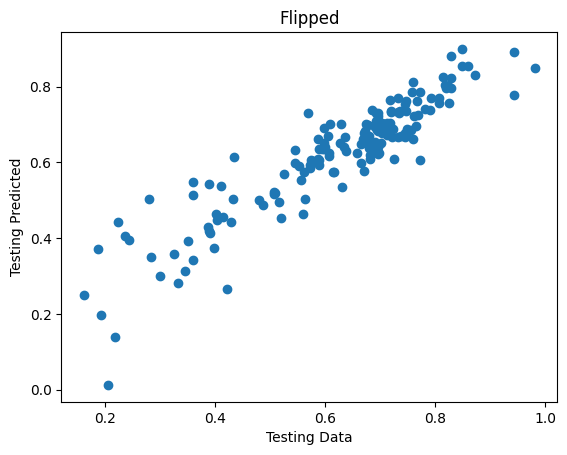

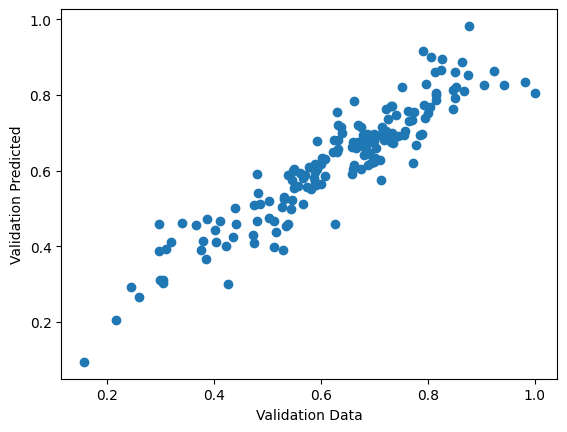

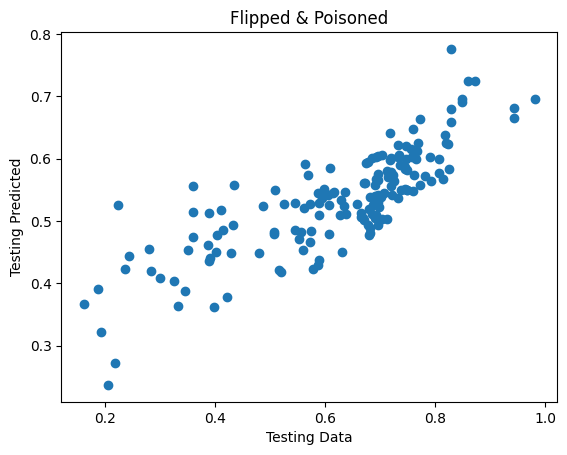

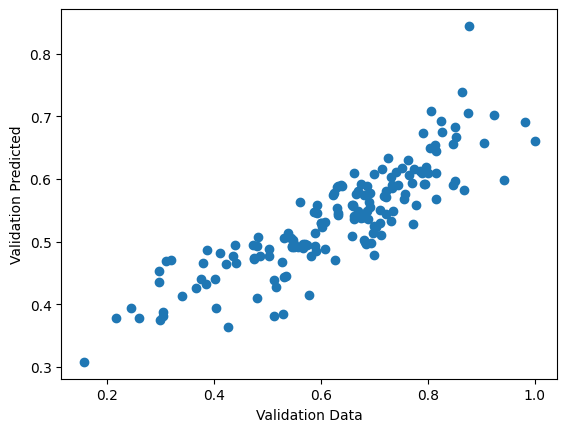


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0037579073460158726 
 Test MSE: 0.004764463167075303

After Flipping & Poisoning:
 Validation MSE:  0.018649730168534853 
 Test MSE: 0.020490195463323202


In [4]:
# flip the data
x_flip, y_flip = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.lasso_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, lam = poiser.learn_model(np.concatenate((poi_train_x, x_flip), axis=0), poi_train_y + y_flip, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_flip = np.matrix(x_flip)
y_flip = y_flip[:]
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = 0.2*(i + 1)*total_prop
    sample_amt = int(train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_flip[:sample_amt,:]
    current_y_pois = y_flip[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])